In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/r-street-quant-challenge/sample_submission.csv
/kaggle/input/r-street-quant-challenge/train_target.csv
/kaggle/input/r-street-quant-challenge/train_data.csv
/kaggle/input/r-street-quant-challenge/test_data.csv


In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, roc_auc_score
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import sigmoid, relu
import math
from tensorflow.keras.losses import BinaryCrossentropy


In [3]:
data_train = pd.read_csv('/kaggle/input/r-street-quant-challenge/train_data.csv')
data_test = pd.read_csv('/kaggle/input/r-street-quant-challenge/test_data.csv')
data_target = pd.read_csv('/kaggle/input/r-street-quant-challenge/train_target.csv')

In [4]:
data_train.head(20)

,Id,date,open,high,low,close,day,week,SMA_7,SMA_14,SMA_21,RSI_7,RSI_14,RSI_21,ATR_14,bb_mavg,bb_hband,bb_lband
0,0,2015-01-12 09:15:00+05:30,0.286419,0.286419,0.280700,0.283200,12,3,0.282429,0.280881,0.281604,54.402627,48.236033,45.263488,0.003152,0.281425,0.287263,0.275588
1,1,2015-01-12 09:30:00+05:30,0.283212,0.283906,0.282044,0.283888,12,3,0.283249,0.281384,0.281543,57.307707,49.928940,46.453986,0.003060,0.281334,0.286954,0.275714
2,2,2015-01-12 09:45:00+05:30,0.283881,0.285950,0.283137,0.285737,12,3,0.284067,0.282031,0.281544,64.423555,54.263566,49.554022,0.003042,0.281356,0.287041,0.275671
3,3,2015-01-12 10:00:00+05:30,0.285725,0.286587,0.284181,0.285513,12,3,0.284630,0.282194,0.281554,62.935127,53.655190,49.190342,0.002997,0.281477,0.287403,0.275551
4,4,2015-01-12 10:15:00+05:30,0.285438,0.287162,0.285388,0.286669,12,3,0.285107,0.282618,0.281724,67.444567,56.362731,51.125779,0.002909,0.281713,0.288056,0.275370
5,5,2015-01-12 10:30:00+05:30,0.286594,0.286762,0.285100,0.285712,12,3,0.285107,0.283007,0.281903,60.359087,53.575063,49.488780,0.002820,0.281879,0.288454,0.275304
6,6,2015-01-12 10:45:00+05:30,0.285725,0.286331,0.284631,0.285544,12,3,0.285180,0.283366,0.282054,59.081205,53.076172,49.196897,0.002740,0.282270,0.288740,0.275799
7,7,2015-01-12 11:00:00+05:30,0.285544,0.286006,0.285100,0.285169,12,3,0.285462,0.283946,0.282408,56.007054,51.919147,48.529046,0.002609,0.282686,0.288765,0.276607
8,8,2015-01-12 11:15:00+05:30,0.285112,0.285781,0.284513,0.285744,12,3,0.285727,0.284488,0.282832,59.753246,53.589769,49.629927,0.002514,0.283139,0.288689,0.277589
9,9,2015-01-12 11:30:00+05:30,0.285750,0.286194,0.284900,0.285119,12,3,0.285638,0.284853,0.283233,53.929622,51.495316,48.447296,0.002426,0.283233,0.288851,0.277616


In [5]:
data_target.head()

,Id,target
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


In [6]:
target = data_target['target']

In [7]:
target

0        1
1        0
2        1
3        0
4        0
        ..
25495    0
25496    1
25497    1
25498    0
25499    0
Name: target, Length: 25500, dtype: int64

In [8]:
t1 = data_train['close']-data_train['low']

In [9]:
t2 = data_train['high'] - data_train['close']

In [10]:
t3 = data_train['open'] - data_train['close']

In [11]:
t = []
for i in range(len(data_train)):
    if t1[i]>t2[i]:
        t.append(0)
    else:
        t.append(1)

In [12]:
print(roc_auc_score(target, t))

0.5006897458000295


In [13]:
# data_df = data_train.resample('60min').pad()
# data_df.head()

In [14]:
target = data_target['target']

In [15]:
data_train['date'] = pd.to_datetime(data_train['date'])

In [16]:
data_train['year'] = data_train['date'].dt.year
data_train['month'] = data_train['date'].dt.month
data_train['day'] = data_train['date'].dt.day
data_train['hour'] = data_train['date'].dt.hour
data_train['minute'] = data_train['date'].dt.minute

In [17]:
data_train['minute'][:20]

0     15
1     30
2     45
3      0
4     15
5     30
6     45
7      0
8     15
9     30
10    45
11     0
12    15
13    30
14    45
15     0
16    15
17    30
18    45
19     0
Name: minute, dtype: int64

In [18]:
time = [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225]

In [19]:
time

[15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225]

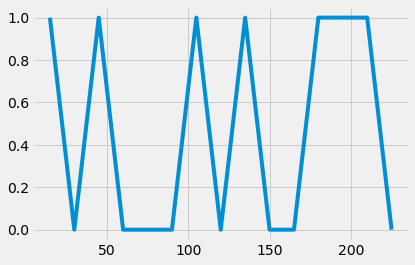

In [20]:
plt.plot(time, target[:15])

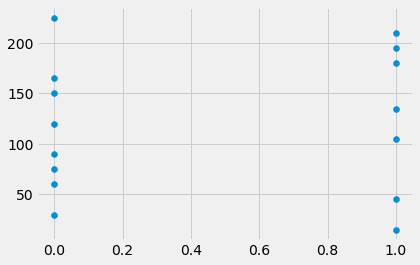

In [21]:
plt.scatter(target[:15], time)

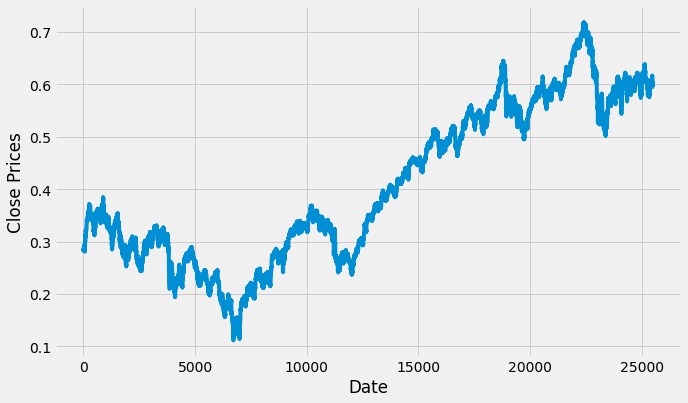

In [22]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data_train['close'])
plt.show()

<AxesSubplot:ylabel='Density'>

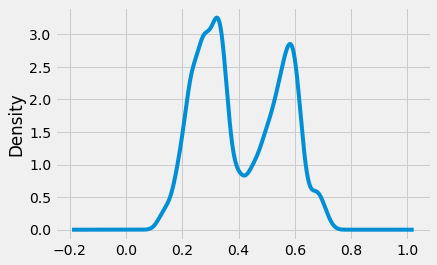

In [23]:
#Distribution of the dataset
df_close = data_train['close']
df_close.plot(kind='kde')

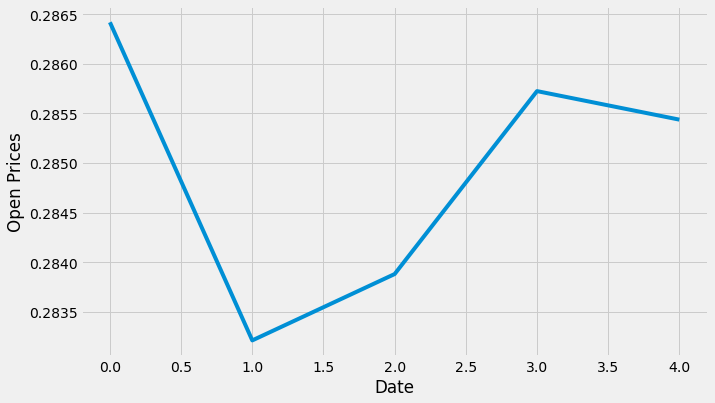

In [24]:
#plot open price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(data_train['open'][:5])
plt.show()

In [25]:
target[:30]

0     1
1     0
2     1
3     0
4     0
5     0
6     1
7     0
8     1
9     0
10    0
11    1
12    1
13    1
14    0
15    1
16    1
17    1
18    1
19    0
20    0
21    1
22    1
23    1
24    1
25    0
26    0
27    1
28    1
29    0
Name: target, dtype: int64

<AxesSubplot:ylabel='Density'>

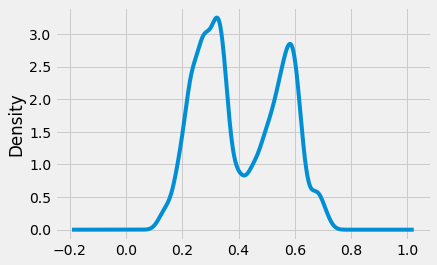

In [26]:
#Distribution of the dataset
df_close = data_train['open']
df_close.plot(kind='kde')

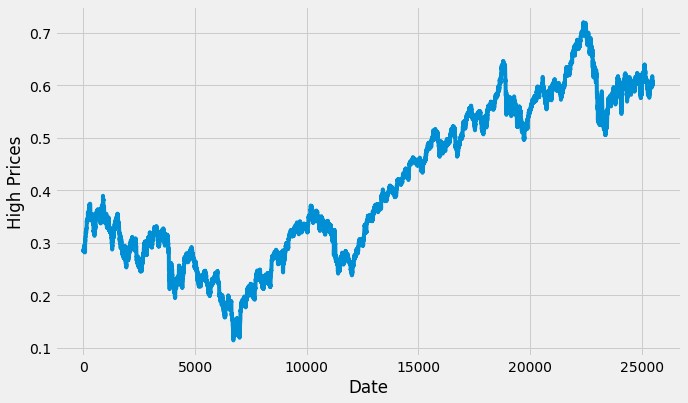

In [27]:
#plot high price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('High Prices')
plt.plot(data_train['high'])
plt.show()

<AxesSubplot:ylabel='Density'>

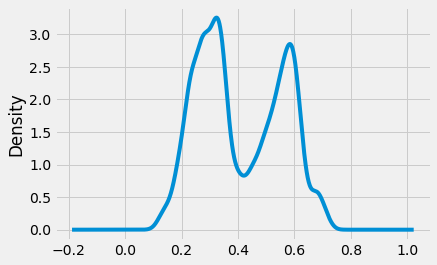

In [28]:
#Distribution of the dataset
df_close = data_train['high']
df_close.plot(kind='kde')

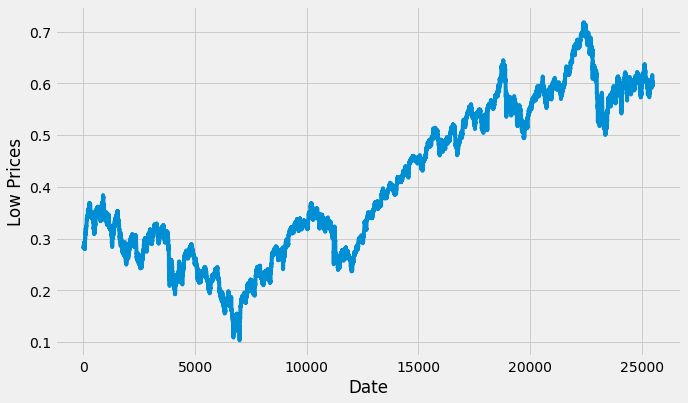

In [29]:
#plot low price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Low Prices')
plt.plot(data_train['low'])
plt.show()

<AxesSubplot:ylabel='Density'>

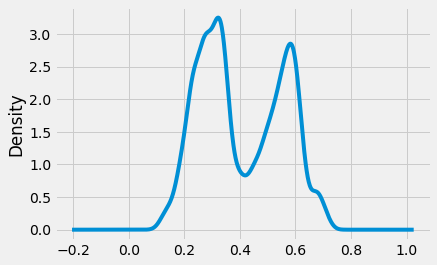

In [30]:
#Distribution of the dataset
df_close = data_train['low']
df_close.plot(kind='kde')

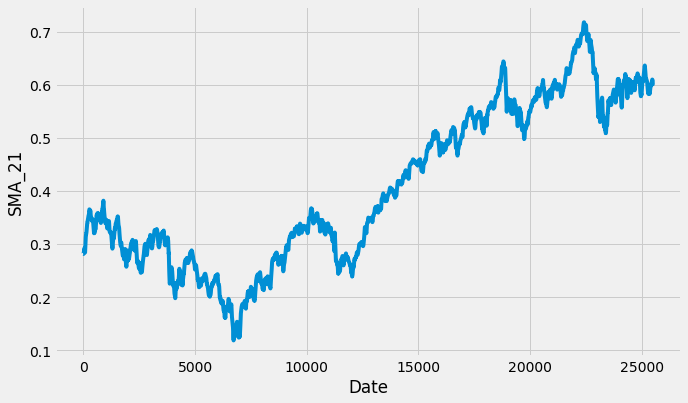

In [31]:
#plot low price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('SMA_21')
plt.plot(data_train['SMA_21'])
plt.show()

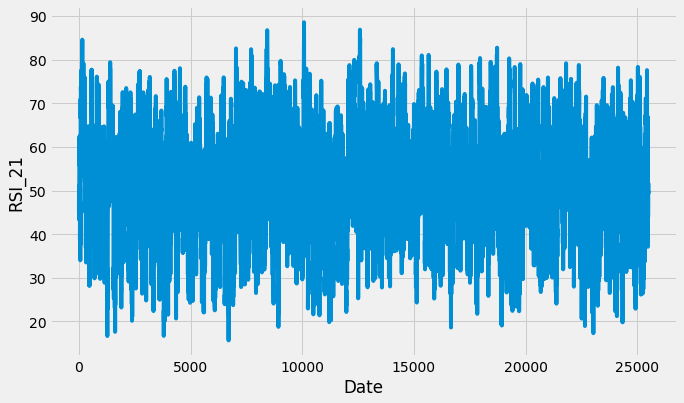

In [32]:
#plot RSI_21 price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('RSI_21')
plt.plot(data_train['RSI_21'])
plt.show()

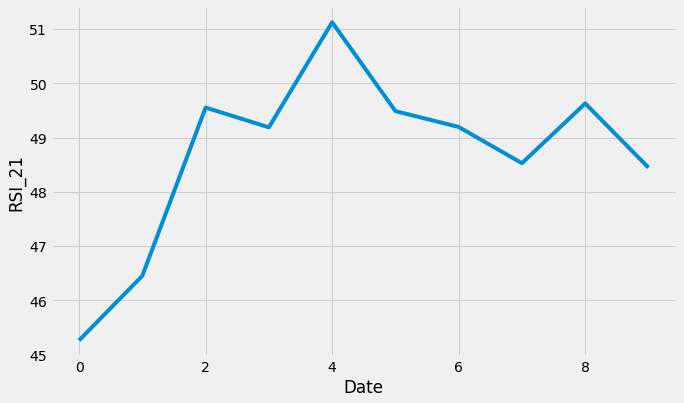

In [33]:
#plot RSI_21 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('RSI_21')
plt.plot(data_train['RSI_21'][:10])
plt.show()

<AxesSubplot:ylabel='Density'>

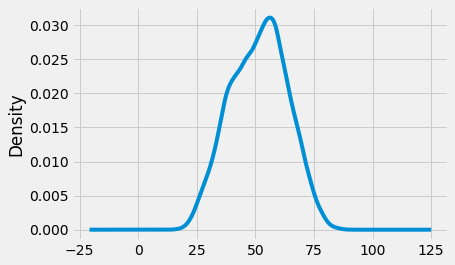

In [34]:
#Distribution of the dataset
df_close = data_train['RSI_21']
df_close.plot(kind='kde')

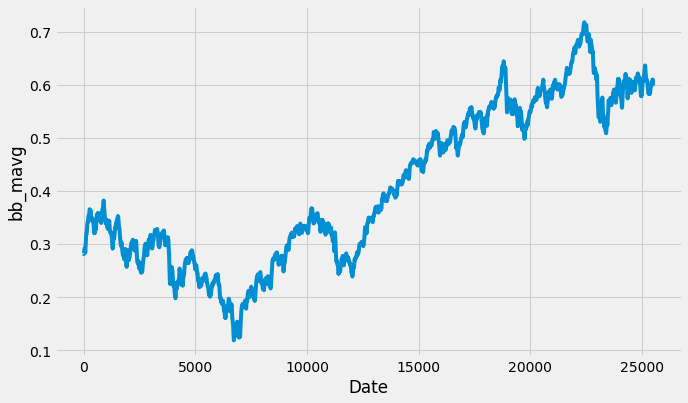

In [35]:
#plot bb_mavg price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('bb_mavg')
plt.plot(data_train['bb_mavg'])
plt.show()

In [36]:
target

0        1
1        0
2        1
3        0
4        0
        ..
25495    0
25496    1
25497    1
25498    0
25499    0
Name: target, Length: 25500, dtype: int64

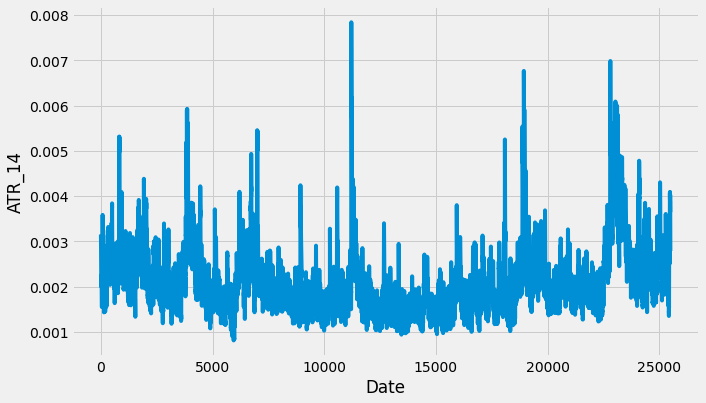

In [37]:
#plot RSI_21 price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('ATR_14')
plt.plot(data_train['ATR_14'])
plt.show()

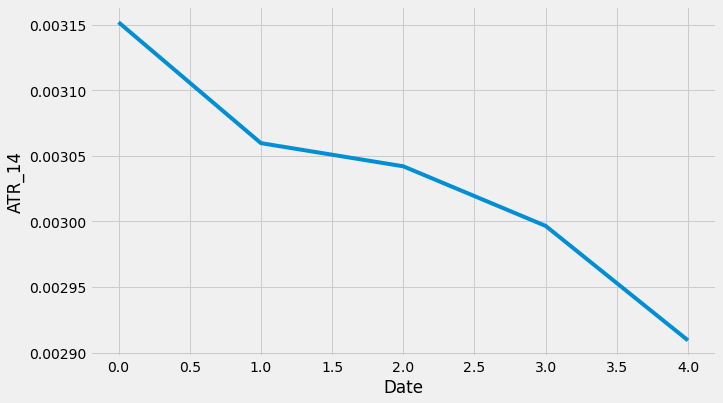

In [38]:
#plot ATR_14
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('ATR_14')
plt.plot(data_train['ATR_14'][:5])
plt.show()

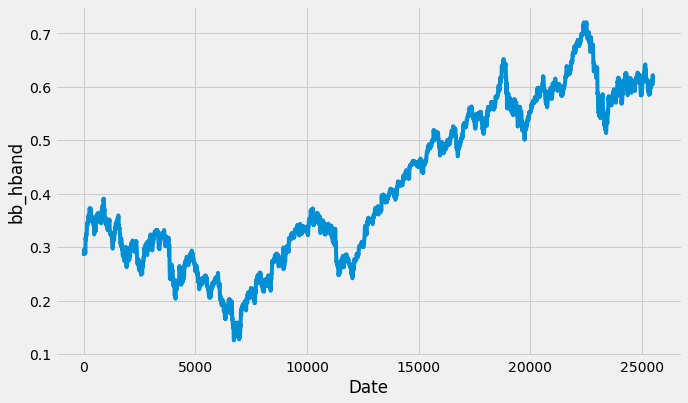

In [39]:
#plot bb_hband price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('bb_hband')
plt.plot(data_train['bb_hband'])
plt.show()

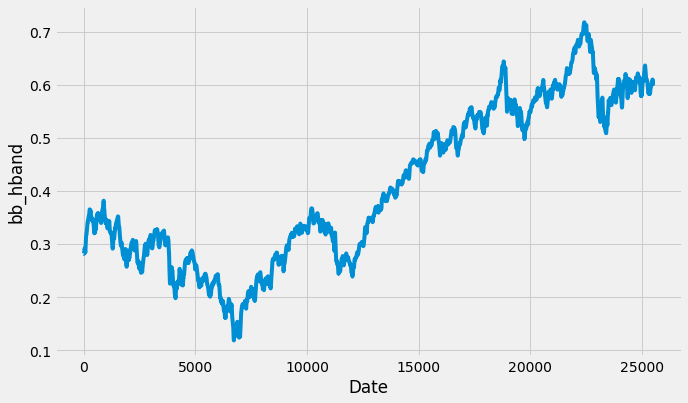

In [40]:
#plot bb_hband price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('bb_hband')
plt.plot(data_train['SMA_21'])
plt.show()

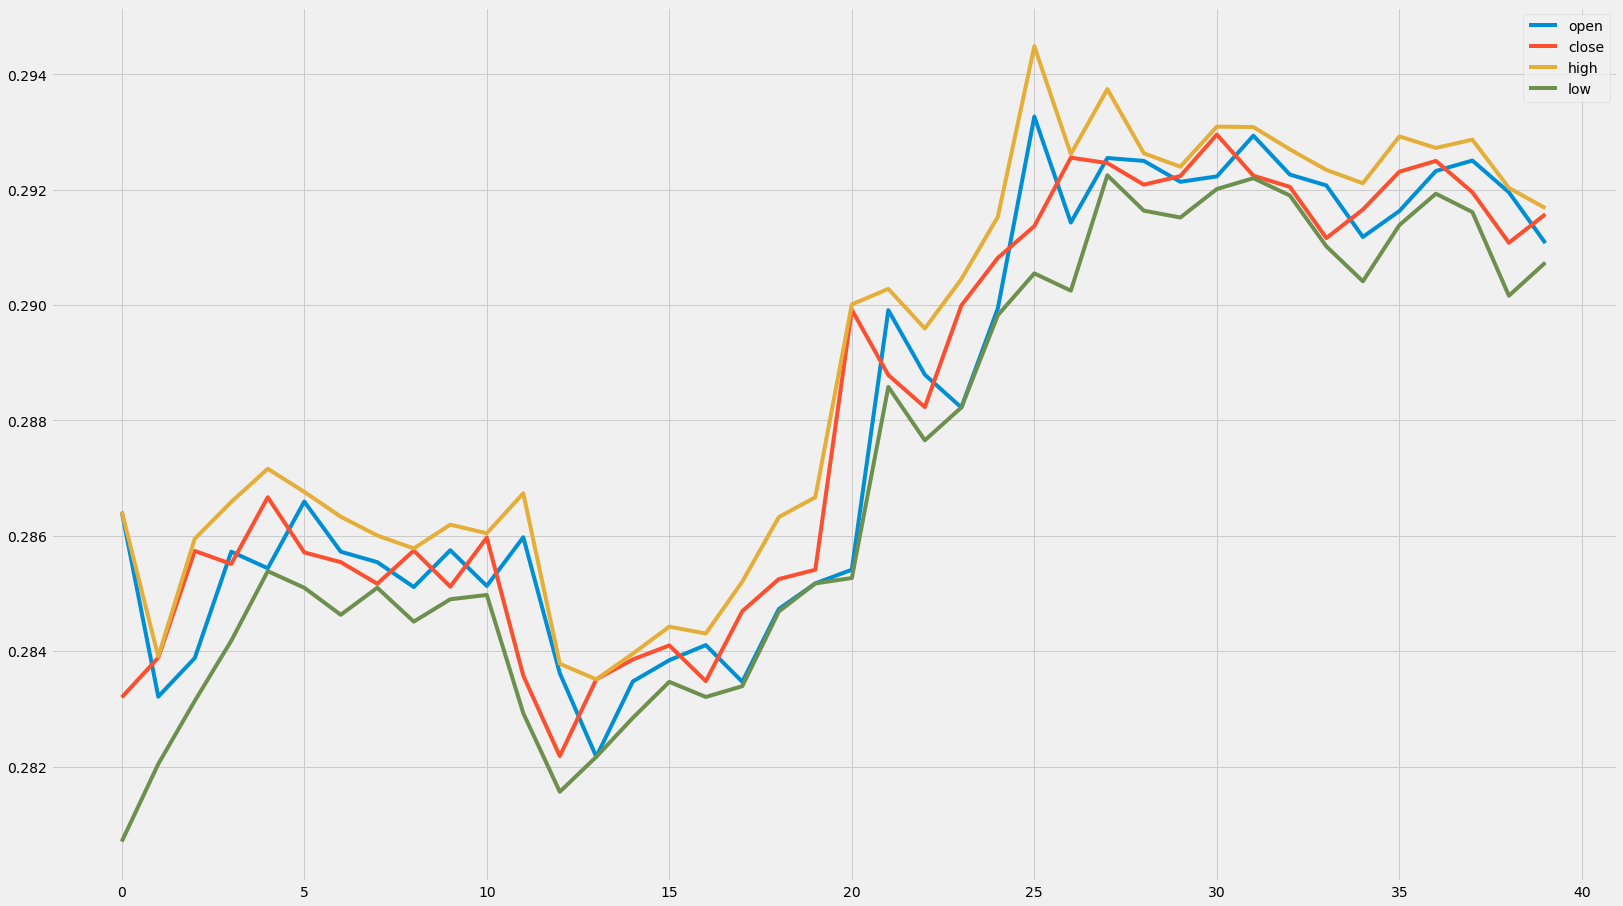

In [41]:
plt.figure(figsize=(25,15))
plt.grid(True)
plt.plot(data_train['open'][:40])
plt.plot(data_train['close'][0:40])
plt.plot(data_train['high'][:40])
plt.plot(data_train['low'][:40])
# plt.plot(target[:100])
plt.legend(['open','close','high','low'])

In [42]:
history = [i for i in data_train['close']]

In [43]:
# Candlestick chart of march 2008
trace = go.Candlestick(open = data_train['open'][:40],
                       close = data_train['close'][0:40],
                       high = data_train['high'][:40],
                       low = data_train['low'][:40])
data = [trace]
iplot(data, filename='simple_candlestick')


In [44]:
y_p = []
for i in range(25500):
    if data_train['close'][i]>data_train['open'][i]:
        y_p.append(1)
    else:
        y_p.append(0)

In [45]:
target_new = []
target_new.append(0)
target_new.append(1)
for i in range(len(target)):
    target_new.append(target[i])


In [46]:
print(roc_auc_score(y_p, target_new[:25500]))

0.9735346401678524


In [47]:
len(target)

25500

In [48]:
t_1 = target[25498]
t_2 = target[25499]

In [49]:
training_set = data_train[:17850]
val_set = data_train[17850:]

In [50]:
col = ['open','high','low', 'close', 'SMA_21']
# col1 = ['close','high','low', 'open']

In [51]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set[col])
val_set_scaled = sc.transform(val_set[col])
test_set_scaled = sc.transform(data_test[col])

In [52]:
# sc1 = MinMaxScaler(feature_range=(0,1))
# training_set_scaled1 = sc1.fit_transform(training_set[col])
# val_set_scaled1 = sc1.transform(val_set[col])
# test_set_scaled1 = sc1.transform(data_test[col])

In [53]:
# training_set_scaled = np.array(data_train[col])
# training_set_scaled1 = np.array(data_train[col1])
# val_set_scaled = np.array(data_train[col])
# val_set_scaled1 = np.array(data_train[col1])

In [54]:
training_set_scaled

array([[0.38935847, 0.38511331, 0.38854288, 0.38223788, 0.37062613],
       [0.38221492, 0.37949306, 0.39148587, 0.38376933, 0.37048709],
       [0.3837049 , 0.38406476, 0.39388132, 0.38789035, 0.3704898 ],
       ...,
       [0.90582485, 0.90662267, 0.90857573, 0.90847453, 0.91204104],
       [0.90835921, 0.9067485 , 0.90943809, 0.90704053, 0.91112808],
       [0.90716166, 0.90568596, 0.90853467, 0.90560653, 0.91027549]])

In [55]:
# target_new = np.array(target_new)
# enc = OneHotEncoder()
# target_new = target_new.reshape(-1, 1)
# enc.fit(target_new)
# enc.transform(target_new)

In [56]:
k = 50

In [57]:
X_train = []
y_train = []
for i in range(k,17850):
    X_train.append(training_set_scaled[i-k:i])
    y_train.append(target_new[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [58]:
# X_train1 = []
# y_train1 = []
# for i in range(k,17850):
#     X_train1.append(training_set_scaled1[i-k:i])
#     y_train1.append(training_set_scaled1[i,0])
# X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

In [59]:
print(X_train.shape, y_train.shape)

(17800, 50, 5) (17800,)


In [60]:
classifier = Sequential()
# First LSTM layer
classifier.add(LSTM(units=32, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
# Second LSTM layer
classifier.add(LSTM(units=32,return_sequences=True))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
# Third LSTM layer
classifier.add(LSTM(units=32))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
# # Fifth GRU layer
# classifier.add(LSTM(units=32, return_sequences=True))
# classifier.add(Dropout(0.2))
# classifier.add(BatchNormalization())
# # Fourth LSTM layer
# classifier.add(LSTM(units=32, return_sequences=True))
# classifier.add(Dropout(0.2))
# classifier.add(BatchNormalization())
# classifier.add(LSTM(units=32))
# classifier.add(Dropout(0.2))
# classifier.add(BatchNormalization())
# classifier.add(Dense(units=8, activation='tanh'))
# classifier.add(BatchNormalization())
classifier.add(Dense(units=1, activation = sigmoid))
classifier.compile(optimizer= 'adam', loss='BinaryCrossentropy')
classifier.fit(X_train, y_train, epochs=20, batch_size=32)

2021-12-11 10:18:50.721494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 10:18:50.820266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 10:18:50.821034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 10:18:50.822121: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2021-12-11 10:18:58.997012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


557/557 [==============================] - 13s 11ms/step - loss: 0.7401
Epoch 2/20
557/557 [==============================] - 6s 11ms/step - loss: 0.7103
Epoch 3/20
557/557 [==============================] - 7s 12ms/step - loss: 0.7005
Epoch 4/20
557/557 [==============================] - 7s 12ms/step - loss: 0.6993
Epoch 5/20
557/557 [==============================] - 7s 12ms/step - loss: 0.6973
Epoch 6/20
557/557 [==============================] - 6s 12ms/step - loss: 0.6954
Epoch 7/20
557/557 [==============================] - 6s 11ms/step - loss: 0.6943
Epoch 8/20
557/557 [==============================] - 7s 12ms/step - loss: 0.6936
Epoch 9/20
557/557 [==============================] - 6s 11ms/step - loss: 0.6940
Epoch 10/20
557/557 [==============================] - 6s 12ms/step - loss: 0.6937
Epoch 11/20
557/557 [==============================] - 6s 11ms/step - loss: 0.6937
Epoch 12/20
557/557 [==============================] - 6s 11ms/step - loss: 0.6932
Epoch 13/20
557/557 [==

In [61]:
X_test = []
for i in range(k, 7650):
    X_test.append(val_set_scaled[i-k:i])
X_test = np.array(X_test)
y_pred = classifier.predict(X_test)

In [62]:
print(y_pred.shape)

(7600, 1)


In [63]:
# classifier1 = Sequential()
# # First LSTM layer
# classifier1.add(LSTM(units=32, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
# classifier1.add(Dropout(0.2))
# classifier1.add(BatchNormalization())
# # Second LSTM layer
# classifier1.add(LSTM(units=32,return_sequences=True))
# classifier1.add(Dropout(0.2))
# classifier1.add(BatchNormalization())
# # Third LSTM layer
# classifier1.add(LSTM(units=32))
# classifier1.add(Dropout(0.2))
# classifier1.add(BatchNormalization())
# classifier1.add(Dense(units=1, activation = sigmoid))
# classifier1.compile(optimizer= 'adam', loss='mean_squared_error')
# classifier1.fit(X_train1, y_train1, epochs=15, batch_size=32)

In [64]:
# X_test1 = []
# for i in range(17850+k, 25500):
#     X_test1.append(val_set_scaled1[i-k:i])
# X_test1 = np.array(X_test1)
# y_pred1 = classifier.predict(X_test1)

In [65]:
# val_set_scaled[17850+k:]

In [66]:
y_pred

array([[0.51059705],
       [0.51059747],
       [0.5105978 ],
       ...,
       [0.5103541 ],
       [0.510355  ],
       [0.5103554 ]], dtype=float32)

In [67]:
# y_p = []
# for i in range(y_pred.shape[0]):
#     if y_pred1[i]>y_pred[i]:
#         y_p.append(1)
#     else:
#         y_p.append(0)

In [68]:
y_val = target_new[17850+k:25500]

In [69]:
print(len(y_val))

7600


In [70]:
print(y_val[:20])

[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]


In [71]:
print("Val_acc", roc_auc_score(y_val, y_pred))

Val_acc 0.5220082305530509


In [72]:
val_set_scaled

array([[0.9056856 , 0.907112  , 0.90809664, 0.90922634, 0.90965283],
       [0.90958462, 0.90814657, 0.90961604, 0.90868336, 0.90917193],
       [0.90862379, 0.90774113, 0.91082061, 0.90960224, 0.90901864],
       ...,
       [1.09534485, 1.09525074, 1.09418931, 1.09443524, 1.09898842],
       [1.09467645, 1.09504103, 1.09418931, 1.09527058, 1.09935944],
       [1.09545625, 1.09519482, 1.09455889, 1.09543765, 1.09984712]])

In [73]:
imd = val_set_scaled[7650-k:]

In [74]:
test_set_scaled.shape

(10317, 5)

In [75]:
test_data = np.vstack((imd, test_set_scaled))

In [76]:
test_data.shape

(10367, 5)

In [77]:
X_test_ = []
for i in range(k, 10317+k):
    X_test_.append(test_data[i-k:i])
X_test_ = np.array(X_test_)
y_sub = classifier.predict(X_test_)

In [78]:
y_sub = np.array(y_sub)
sub = pd.DataFrame()
sub['Id'] = data_test['Id']
sub['target'] = y_sub
sub.to_csv('sample_submission.csv', index=False)


In [79]:
sub.head()

,Id,target
0,0,0.510355
1,1,0.510357
2,2,0.510360
3,3,0.510361
4,4,0.510362
